# peaker_historical_tests.ipynb
A notebook that tests the performance of the peak_tester against historical data

## Load packages and define functions

In [1]:
import os, sys
sys.path.append('../scripts')

from peak_tester import EmissionsPeakTest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w', encoding='utf-8')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
# Function for running over different year ranges and testing whether, at this point, you would have seen this as a peak
def run_historical_peak_test(csv_file, region, num_years_forward=3,
                             noise_method = 'lowess',
                             noise_type='t-dist', noise_params=None,
                             bootstrap_method='ar_bootstrap', 
                             years_to_check = range(1990,2022), years_for_analysis = range(1970,2025),
                             null_hypothesis = None,
                             n_years_for_trend = 5,
                             all_years = False):
    """
    Advanced version with more customization options.
    
    Parameters:
    -----------
    csv_file : str
        Path to historical data CSV file
    num_years_forward : int
        Number of years to include in each test
    noise_method: str
        lowess, broken_trend, linear_w_autocorrelation, linear, hp, hamilton, spline 
    noise_type : str
        Type of noise: 'normal', 't-dist', or 'empirical'
    noise_params : dict, optional
        Parameters for characterize_noise (e.g., {'fraction': 0.8, 't_df': 3})
    bootstrap_method : str
        Bootstrap method to use
    years_to_check: range
        years to run analysis for
    years for analysis: range
        years to input into the residuals analysis
    null_hypothesis: int or str
        growth rate to use or 'recent_trend'
    n_years_for_trend: int
        number of years for recent trend (default 5)
    all_years: bool: default = False
        Decides whether all years (even those which are theoretically "future" are used for noise parameterisation)
    
        
    
    Returns:
    --------
    pd.DataFrame with results and additional metadata
    """

    
    # Initialize
    peak_tester = EmissionsPeakTest()
    peak_tester.load_historical_data(csv_file, region = region, year_range=years_for_analysis)
    hist_data = peak_tester.historical_data
    
    results = []
    
    
    for year in years_to_check:
        # Check if all required years exist in data
        years_needed = [year + i for i in range(num_years_forward)]
        if not all(y in hist_data.year.values for y in years_needed):
            print(f"Warning: Skipping year {year} - insufficient forward data")
            continue
        
        # Get emissions data
        emissions_data = []
        for test_year in years_needed:
            em_value = hist_data.loc[hist_data.year == test_year, 'emissions'].squeeze()
            emissions_data.append((test_year, em_value))

        # Run test
        with HiddenPrints():
            # cut historical data off at year of analysis if 'all_years' is False (default)
            if not all_years:
                peak_tester.historical_data = hist_data.query(f'year <= {year+num_years_forward-1}').copy()

            # add 'test data' (year + number of years forward)
            peak_tester.set_test_data(emissions_data) 
            
            if noise_params:
                peak_tester.characterize_noise(method=noise_method, 
                                              noise_type=noise_type, 
                                              **noise_params)
            else:
                peak_tester.characterize_noise(method=noise_method, 
                                              noise_type=noise_type)
            
            
            peak_tester.create_noise_generator()

            
            if isinstance(null_hypothesis, int):
                trend = hist_data.loc[hist_data['year']==year, 'emissions'].squeeze()*-1*null_hypothesis
                print(f"Using custom null hypothesis growth rate: {null_hypothesis}, meaning a trend of {trend}")
                peak_tester.run_complete_bootstrap_test(bootstrap_method=bootstrap_method,
                                                                                     null_hypothesis = trend)
                null_hyp = null_hypothesis
            elif null_hypothesis == 'recent_trend':
                peak_tester.run_complete_bootstrap_test(bootstrap_method=bootstrap_method,
                                                        null_hypothesis = 'recent_trend',
                                                        n_years_for_trend = n_years_for_trend)
                print(f"Using recent trend from last {n_years_for_trend} years of {peak_tester.recent_historical_trend}")
                null_hyp = null_hypothesis
            else:
                print("Using default null hypothesis (None)")
                peak_tester.run_complete_bootstrap_test(bootstrap_method=bootstrap_method)
                null_hyp = 'default'
            
            # Store results with metadata
            results.append({
                'year': year,
                'region': region,
                'p-value': peak_tester.bootstrap_results['p_value_one_tail'],
                'num_years_forward': num_years_forward,
                'noise_type': noise_type,
                'method': noise_method,
                'parameters': noise_params,
                'null_hypothesis': null_hyp,
            })
            results_df = pd.DataFrame(results)

    
    return pd.DataFrame(results_df)

# # Example with noise parameters
# pdf_advanced = run_historical_peak_test(
#     csv_file='gcb_hist_co2.csv',
#     num_years_forward=4,
#     noise_type='t-dist',
#     noise_params={'fraction': 0.75, 't_df': 5},
#     bootstrap_method='ar_bootstraif null_hypothesis is int:p'
# )

## Run initial historical tests on emissions

In [4]:
pdf_2year = run_historical_peak_test(
    csv_file='gcb_hist_co2.csv', region='WLD',
    num_years_forward=2,
    noise_method = 'lowess', noise_type='t-dist',
    years_to_check=range(1990,2022),years_for_analysis=range(1970,2025), all_years=False)

Loaded historical data: 1970-2024
Data points: 55


In [7]:
pdf_2year.to_csv('results/historical_tests/two_year_co2_lowess.csv')

In [39]:
pdf_3year_lowess = run_historical_peak_test(
    csv_file='gcb_hist_co2.csv', region='WLD',
    num_years_forward=3,
    noise_method = 'lowess', noise_type='t-dist',
    years_to_check=range(1990,2022),years_for_analysis=range(1970,2025), all_years=False)
pdf_3year_lowess.to_csv('results/historical_tests/three_year_co2_lowess.csv')

Loaded historical data: 1970-2024
Data points: 55


In [12]:
pdf_3year_allmethods = {}
for method in ['lowess', 'hamilton', 'broken_trend', 'linear_w_autocorrelation']:
    pdf_3year_allmethods[method] =  run_historical_peak_test(csv_file='gcb_hist_co2.csv', region = 'WLD', num_years_forward=3, noise_method = method, noise_type = 't-dist')


Loaded historical data: 1970-2024
Data points: 55
Loaded historical data: 1970-2024
Data points: 55
Loaded historical data: 1970-2024
Data points: 55
Loaded historical data: 1970-2024
Data points: 55


In [15]:
for method, df in pdf_3year_allmethods.items():  
    df.to_csv(f'results/historical_tests/three_year_co2_method_{method}.csv')

In [16]:
# Include all historical years in each analysis (i.e. all historical years are included in the noise parameterisation for each historical year)
# using 3 years forward

peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data('gcb_hist_co2.csv', region = 'WLD', year_range = range(1970,2024))
peak_tester.characterize_noise(method='lowess', noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
peak_tester.create_noise_generator()

p_list = []
years_to_check = np.arange(1975, 2022, 1)
for year in years_to_check:
    years_to_test = [year, year+1, year+2, year+3]
    
    em_0 = peak_tester.historical_data.loc[peak_tester.historical_data.year==year,'emissions'].squeeze()
    em_1 = peak_tester.historical_data.loc[peak_tester.historical_data.year==year+1,'emissions'].squeeze()
    em_2 = peak_tester.historical_data.loc[peak_tester.historical_data.year==year+2,'emissions'].squeeze()
    em_3 = peak_tester.historical_data.loc[peak_tester.historical_data.year==year+2,'emissions'].squeeze()

    # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
    with HiddenPrints():
        peak_tester.set_test_data([
                (year, em_0),
                (year+1, em_1), 
                (year+2, em_2),
                (year+3, em_3),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        p_list.append(peak_tester.bootstrap_results['p_value_one_tail'])
    
pdf_3year_allyears = pd.DataFrame({
    'year': years_to_check,
    'p-value': p_list
})
pdf_3year_allyears.to_csv('results/historical_tests/three_year_co2_allyears_lowess.csv')

Loaded historical data: 1970-2023
Data points: 54
using t-dist distribution to calculate noise
Fitted t-distribution to innovations: df = 4.7
Autocorrelation analysis:

  Lag-1 autocorr: 0.434
  Residual σ (post-autocorrelation): 468.2
  Has significant autocorr: True
  Likelihood of autocorr: 0.9988770184066517
Noise characterization complete:
  Method used: lowess
Using AR(1) noise generator with φ=0.43, mean=0.000, sigma=468.164


## Plot results

In [56]:


def plot_peak_analysis(historical_data, pdf_results, variable= 'emissions', threshold=0.66, 
                       figsize=(12, 6), savepath=None):
    """
    Plot peak analysis with historical emissions and multiple p-value time series.
    
    Parameters
    ----------
    historical_data : DataFrame
        DataFrame with 'year' and 'emissions' columns
    pdf_results : list of dict
        Each dict should contain:
        - 'data': DataFrame with 'year' and 'p-value' columns
        - 'label': str, label for legend
        - 'color': str, line color (optional)
        - 'marker': str, marker style (optional, default 'o')
        - 'linestyle': str, line style (optional, default '-')
        - 'markersize': int, marker size (optional, default 3)
    variable: str
        'emissions' or 'carbon intensity'
    threshold : float
        P-value threshold to plot as horizontal line (default 0.66)
    figsize : tuple
        Figure size (default (12, 6))
    savepath : str
        Path to save figure (optional)
    
    Returns
    -------
    fig, (ax1, ax2) : matplotlib figure and axes
    
    Example
    -------
    pdf_results = [
        {'data': pdf_allyears, 'label': 'All years, 3 year, t-dist', 
         'color': 'tab:blue', 'linestyle': 'dashed'},
        {'data': pdf_3year, 'label': 'Historical only, 3 year, t-dist', 
         'color': 'navy', 'marker': 'o'},
        {'data': pdf_2year, 'label': 'Historical only, 2 year, t-dist', 
         'color': 'lightblue', 'marker': 's', 'linestyle': 'dotted'}
    ]
    fig, axes = plot_peak_analysis(peak_tester.historical_data, pdf_results)
    """
    
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Plot emissions on the first y-axis
    ax1.set_ylabel(variable, color='black', fontsize=12)
    ax1.plot(historical_data.year, historical_data.emissions, 
             color='gray', linewidth=1.2, label='Historical Emissions', alpha=0.5)
    ax1.tick_params(axis='y', labelcolor='black')
    
    # Create 2nd y axis for p-values
    ax2 = ax1.twinx()
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('P-value', color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.grid(True, alpha=0.3)
    
    # Plot each PDF result
    max_p = 0
    for pdf_result in pdf_results:
        data = pdf_result['data']
        label = pdf_result['label']
        color = pdf_result.get('color', 'tab:blue')
        marker = pdf_result.get('marker', 'o')
        linestyle = pdf_result.get('linestyle', '-')
        markersize = pdf_result.get('markersize', 3)
        
        ax2.plot(data['year'], 1 - data['p-value'], 
                color=color, marker=marker, linestyle=linestyle,
                linewidth=2, label=label, markersize=markersize, alpha = 0.7)
        
        # Track maximum p-value for y-axis limits
        max_p = max(max_p, data['p-value'].max())
    
    # Add horizontal line at threshold
    ax2.axhline(y=threshold, color='red', linestyle='--', alpha=0.5, 
                label=f'p={threshold} threshold')
    
    # Set y-limits for p-values with some padding
    ax2.set_ylim(0, max_p * 1.1)
    
    # Add title
    plt.title('Peak Analysis: P-values and Historical Emissions', 
              fontsize=14, pad=20)
    fig.tight_layout()
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', 
               frameon=True, fancybox=True, shadow=True)
    
    # Save if path provided
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    
    return fig, (ax1, ax2)

In [71]:
peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', region='WLD', year_range = range(1970,2025))

Loaded historical data: 1970-2024
Data points: 55


In [72]:
peak_tester.historical_data

,year,emissions
119,1970,14899.138411
120,1971,15503.863654
121,1972,16224.580565
122,1973,17077.286046
123,1974,16997.911601
124,1975,16988.476747
125,1976,17862.491712
126,1977,18358.038672
127,1978,19024.741329
128,1979,19508.590475


In [25]:
# Read in data

pdf_2year = pd.read_csv('results/historical_tests/two_year_co2_lowess.csv')
pdf_3year = pd.read_csv('results/historical_tests/three_year_co2_lowess.csv')
pdf_3year_allyears = pd.read_csv('results/historical_tests/three_year_co2_allyears_lowess.csv')

pdf_3year_m = {}
for method in ['lowess', 'hamilton', 'broken_trend', 'linear_w_autocorrelation']:
    pdf_3year_m[method] = pd.read_csv(f'results/historical_tests/three_year_co2_method_{method}.csv')

Loaded historical data: 1970-2019
Data points: 50


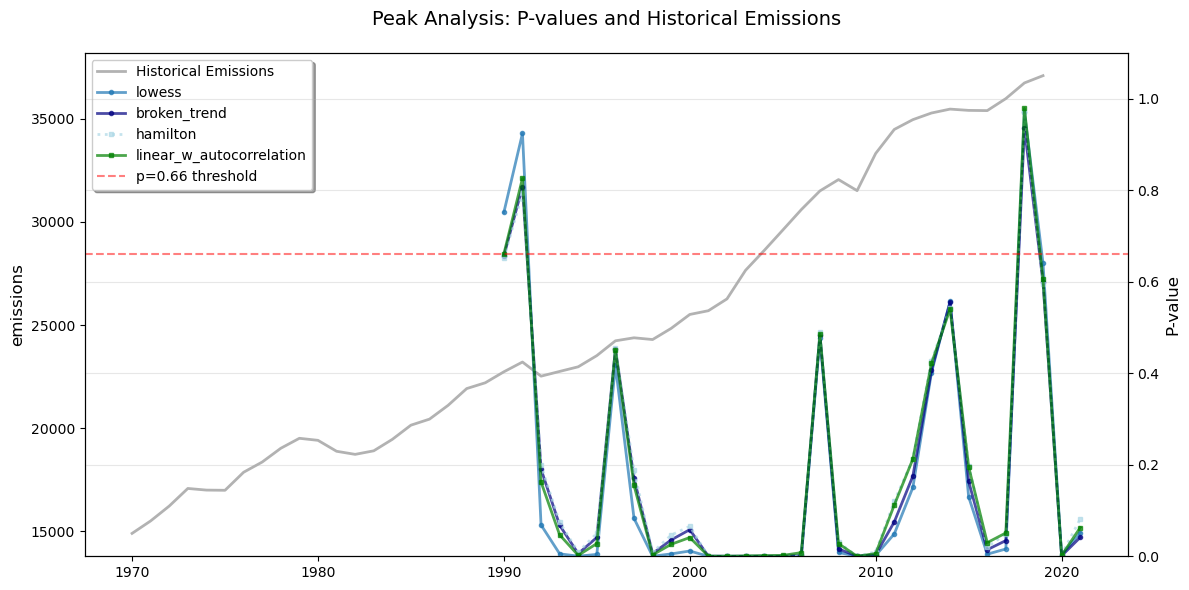

In [52]:
# Plotting p-values for each method
pdf_results = [
    {
        'data': pdf_3year_m['lowess'], 
        'label': 'lowess',
        'color': 'tab:blue',
        'marker': 'o'
    },
    {
        'data': pdf_3year_m['broken_trend'], 
        'label': 'broken_trend',
        'color': 'navy',
        'marker': 'o'
    },
    {
        'data': pdf_3year_m['hamilton'], 
        'label': 'hamilton',
        'color': 'lightblue',
        'marker': 's',
        'linestyle': 'dotted'
    },
    {
        'data': pdf_3year_m['linear_w_autocorrelation'], 
        'label': 'linear_w_autocorrelation',
        'color': 'green',
        'marker': 's'
    }
]

# Create the plot
fig, axes = plot_peak_analysis(
    EmissionsPeakTest().load_historical_data("gcb_hist_co2.csv","WLD").historical_data, 
    pdf_results,
    threshold=0.66,
    savepath="../figures/historical_method_comparison.png"
)
plt.show()

Loaded historical data: 1970-2019
Data points: 50


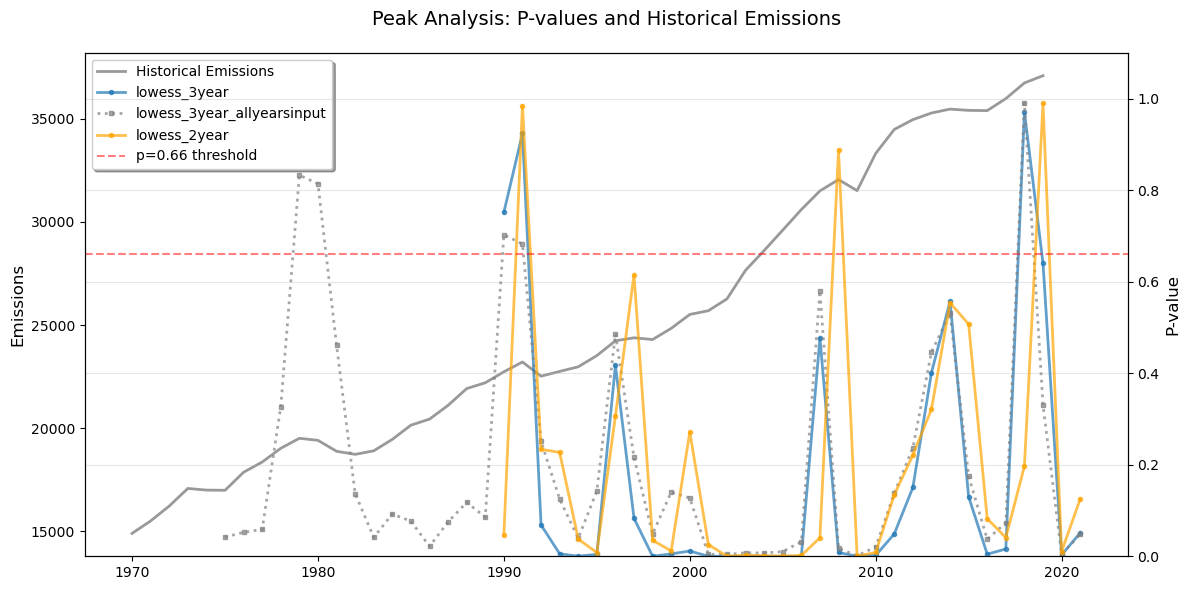

In [42]:
# Comparing results with 2 vs 3 years of test data and with all years included in noise analysis

pdf_results = [
    {
        'data': pdf_3year_m['lowess'], 
        'label': 'lowess_3year',
        'color': 'tab:blue',
        'marker': 'o'
    },
    {
        'data': pdf_3year_allyears, 
        'label': 'lowess_3year_allyearsinput',
        'color': 'grey',
        'marker': 's',
        'linestyle': 'dotted'
    },
    {
        'data': pdf_2year, 
        'label': 'lowess_2year',
        'color': 'orange',
        'marker': 'o'
    },


]

# Create the plot
fig, axes = plot_peak_analysis(
    EmissionsPeakTest().load_historical_data("gcb_hist_co2.csv","WLD").historical_data, 
    pdf_results,
    threshold=0.66,
    savepath="../figures/historical_comparison_nyears.png"
)
plt.show()

## Check difference between 2, 3 and 4 year tests around covid time

In [45]:
pdf_4yr = run_historical_peak_test(
    csv_file = 'gcb_hist_co2.csv',
    region = 'WLD',
    num_years_forward = 4,
    noise_method = 'lowess',
    noise_type = 't-dist',
    noise_params = {'fraction': 0.3},
    bootstrap_method='ar_bootstrap',
    years_to_check = range(2017,2023),
    years_for_analysis = range(1970,2025))

Loaded historical data: 1970-2024
Data points: 55


Loaded historical data: 1970-2019
Data points: 50


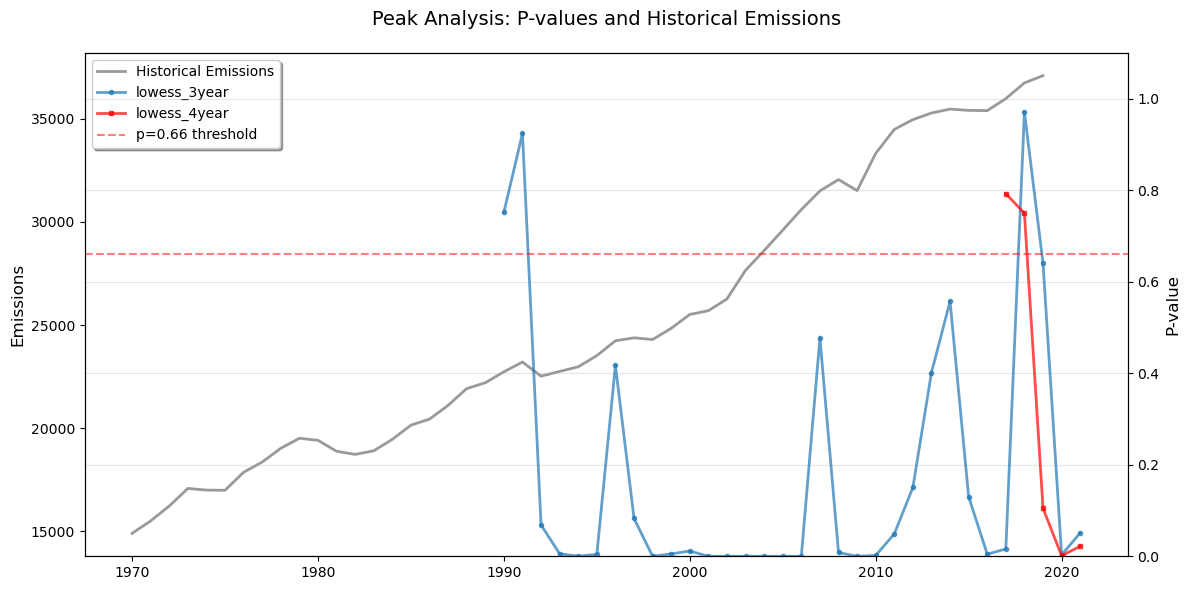

In [51]:
# check if 4 years of data changes covid peak

pdf_results = [
    {
        'data': pdf_3year_m['lowess'], 
        'label': 'lowess_3year',
        'color': 'tab:blue',
        'marker': 'o'
    },
    {
        'data': pdf_4yr, 
        'label': 'lowess_4year',
        'color': 'red',
        'marker': 's',
    },
]

# Create the plot
fig, axes = plot_peak_analysis(
    EmissionsPeakTest().load_historical_data("gcb_hist_co2.csv","WLD").historical_data, 
    pdf_results,
    threshold=0.66,
    savepath="../figures/historical_comparison_4years.png"
)
plt.show()

## Carbon intensity

In [5]:
fossil_co2 = pd.read_csv('../data/processed/gcb_hist_co2.csv')
gdp = pd.read_csv('../data/processed/wdi_gdp.csv')
ci = pd.read_csv('../data/processed/carbon_intensity_gdp.csv')

co2_wld = fossil_co2.loc[fossil_co2['region']=='WLD']
gdp_wld = gdp.loc[gdp['region']=='WLD']
ci_wld = ci.loc[ci['region']=='WLD']


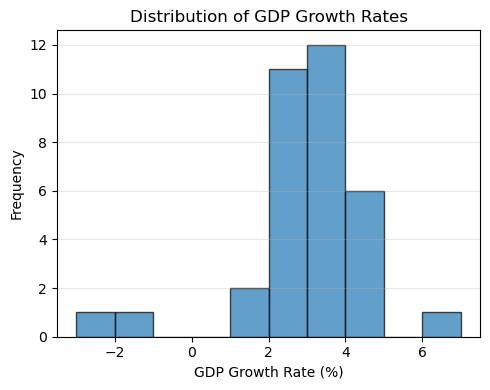

In [42]:
# calculate GDP growth, to indicate what CI reduction rates to use for the null hypothesis
years = np.arange(1990, 2024, 1)
gdp_growth_rate = []
for year in years:
    gdp_growth_rate.append([year, (gdp.loc[gdp['region']=='WLD', str(year)].squeeze() / gdp.loc[gdp['region']=='WLD', str(year-1)].squeeze())-1])

gdp_growth = pd.DataFrame(gdp_growth_rate, columns = ['year', 'growth'])
# Frequency plot of GDP growth rates over time period - shows 2 and 3% are the most common
growth_rates = gdp_growth['growth']*100

# Define bins with 1% width
bins = np.arange(np.floor(growth_rates.min()), 
                 np.ceil(growth_rates.max()) + 1, 
                 1)  # 1% bands

# Create the histogram
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(growth_rates, bins=bins, edgecolor='black', alpha=0.7)

ax.set_xlabel('GDP Growth Rate (%)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of GDP Growth Rates')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

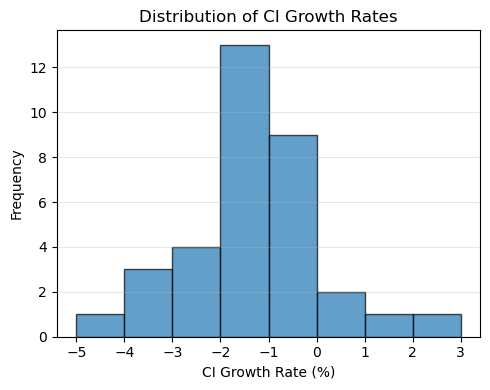

In [43]:
# calculate recent CI reduction rates 
years = np.arange(1990, 2024, 1)
ci_growth_rate = []
for year in years:
    ci_growth_rate.append([year, (ci.loc[ci['region']=='WLD', str(year)].squeeze() / ci.loc[ci['region']=='WLD', str(year-1)].squeeze())-1])

ci_growth = pd.DataFrame(ci_growth_rate, columns = ['year', 'growth'])

# Frequency plot of GDP growth rates over time period - shows 2 and 3% are the most common
growth_rates = ci_growth['growth']*100

# Define bins with 1% width
bins = np.arange(np.floor(growth_rates.min()), 
                 np.ceil(growth_rates.max()) + 1, 
                 1)  # 1% bands

# Create the histogram
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(growth_rates, bins=bins, edgecolor='black', alpha=0.7)

ax.set_xlabel('CI Growth Rate (%)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of CI Growth Rates')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

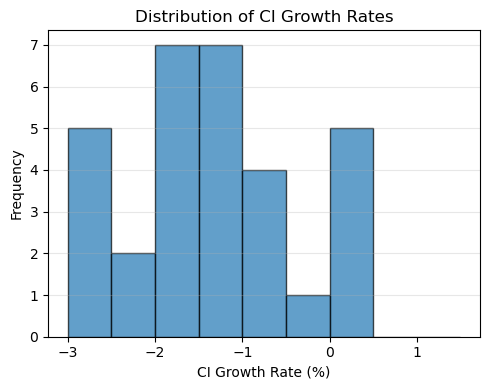

In [46]:
years = np.arange(1993, 2024, 1)  # Start from 1993 (needs 3 years prior)
ci_growth_rate = []
for year in years:
    ci_t = ci.loc[ci['region']=='WLD', str(year)].squeeze()
    ci_t_minus_3 = ci.loc[ci['region']=='WLD', str(year-3)].squeeze()
    cagr_3yr = (ci_t / ci_t_minus_3)**(1/3) - 1
    ci_growth_rate.append([year, cagr_3yr])
ci_growth = pd.DataFrame(ci_growth_rate, columns = ['year', 'cagr_3yr'])

# Frequency plot of GDP growth rates over time period - shows 2 and 3% are the most common
growth_rates = ci_growth['cagr_3yr']*100

# Define bins with 1% width
bins = np.arange(np.floor(growth_rates.min()), 
                 np.ceil(growth_rates.max()) + 1, 
                 0.5)  # 1% bands

# Create the histogram
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(growth_rates, bins=bins, edgecolor='black', alpha=0.7)

ax.set_xlabel('CI Growth Rate (%)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of CI Growth Rates')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
# CI historical analysis using 2% and 3% as null hypotheses (also options to investigate different fractions)
years_to_check = range(1990,2022)
years_for_analysis = range(1970,2025)
all_results = []

for growth in [0.02, 0.03]:
    for frac in [0.3]: #0.15, 0.175, 0.2, 0.225, 0.25,
        results = run_historical_peak_test(csv_file='carbon_intensity_gdp.csv', 
                                              region = 'WLD', num_years_forward=3, noise_method = 'lowess', noise_type='t-dist',
                                              years_to_check = years_to_check, years_for_analysis = years_for_analysis,
                                              null_hypothesis = growth, noise_params = {'fraction': frac})
        all_results.append(results)

ci_results = pd.concat(all_results, ignore_index=True)
ci_results.to_csv('results/historical_tests/carbon_intensity_historical_2_3.csv')

In [56]:
# If results already exist
ci_results = pd.read_csv('results/historical_tests/carbon_intensity_historical_2_3.csv')

In [48]:
# use recent trend for null hypothesis
years_to_check = range(1980,2022)
years_for_analysis = range(1970,2025)
all_results = []


for frac in [0.3]: #0.15, 0.175, 0.2, 0.225, 0.25,
    results = run_historical_peak_test(csv_file='carbon_intensity_gdp.csv', 
                                          region = 'WLD', num_years_forward=3, noise_method = 'broken_trend', noise_type='t-dist',
                                          years_to_check = years_to_check, years_for_analysis = years_for_analysis,
                                          null_hypothesis = 'recent_trend', n_years_for_trend = 5, noise_params = {'fraction': frac})
    all_results.append(results)

ci_results_rt = pd.concat(all_results, ignore_index=True)
ci_results_rt.to_csv('results/historical_tests/carbon_intensity_historical_recent_trend_5_bt.csv')

# years_to_check = range(1985,2022)
# years_for_analysis = range(1970,2025)
# all_results = []


# for frac in [0.3]: #0.15, 0.175, 0.2, 0.225, 0.25,
#     results = run_historical_peak_test(csv_file='carbon_intensity_gdp.csv', 
#                                           region = 'WLD', num_years_forward=3, noise_method = 'lowess', noise_type='t-dist',
#                                           years_to_check = years_to_check, years_for_analysis = years_for_analysis,
#                                           null_hypothesis = 'recent_trend', n_years_for_trend = 20, noise_params = {'fraction': frac})
#     all_results.append(results)

# ci_results_rt = pd.concat(all_results, ignore_index=True)
# ci_results_rt.to_csv('results/historical_tests/carbon_intensity_historical_recent_trend_20.csv')


Loaded historical data: 1970-2024
Data points: 55


Loaded historical data: 1970-2024
Data points: 55
Loaded historical data: 1970-2024
Data points: 55


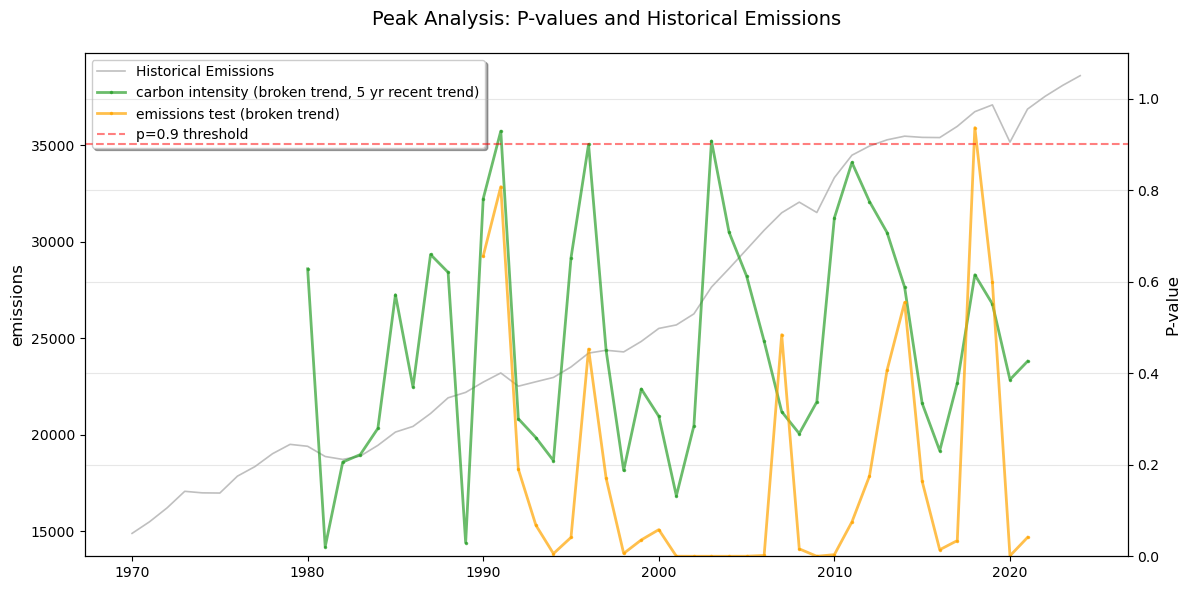

In [76]:
# Plotting p-values for each method
ci_results_rt = pd.read_csv('results/historical_tests/carbon_intensity_historical_recent_trend_10.csv')
ci_results_rt_5 = pd.read_csv('results/historical_tests/carbon_intensity_historical_recent_trend_5.csv')
ci_results_rt_5_bt = pd.read_csv('results/historical_tests/carbon_intensity_historical_recent_trend_5_bt.csv')
ci_results_rt_20 = pd.read_csv('results/historical_tests/carbon_intensity_historical_recent_trend_20.csv')

pdf_results = [
    # {
    #     'data': ci_results_rt,
    #     'label': '10yr recent trend null hypothesis',
    #     'color': 'tab:green',
    #     'linestyle': 'dotted',
    #     'marker': 'o',
    # },
        {
        'data': ci_results_rt_5_bt,
        'label': 'carbon intensity (broken trend, 5 yr recent trend)',
        'color': 'tab:green',
        'marker': '.',
    },
        {
        'data': pdf_3year_m['broken_trend'], 
        'label': 'emissions test (broken trend)',
        'color': 'orange',
        'marker': '.'
    },
    #         {
    #     'data': ci_results_rt_20, 
    #     'label': '20 year',
    #     'color': 'pink',
    #     'marker': 'o'
    # },
]

hist_emissions = EmissionsPeakTest().load_historical_data('gcb_hist_co2.csv', "WLD", year_range = range(1970,2025)).historical_data
hist_ci = EmissionsPeakTest().load_historical_data('carbon_intensity_gdp.csv', "WLD", year_range = range(1970,2025)).historical_data
# Create the plot
fig, axes = plot_peak_analysis(
    hist_emissions, 
    pdf_results,
    variable = 'emissions',
    threshold=0.9,
    # savepath="../figures/historical_method_comparison.png"
)

plt.show()

Loaded historical data: 1970-2024
Data points: 55


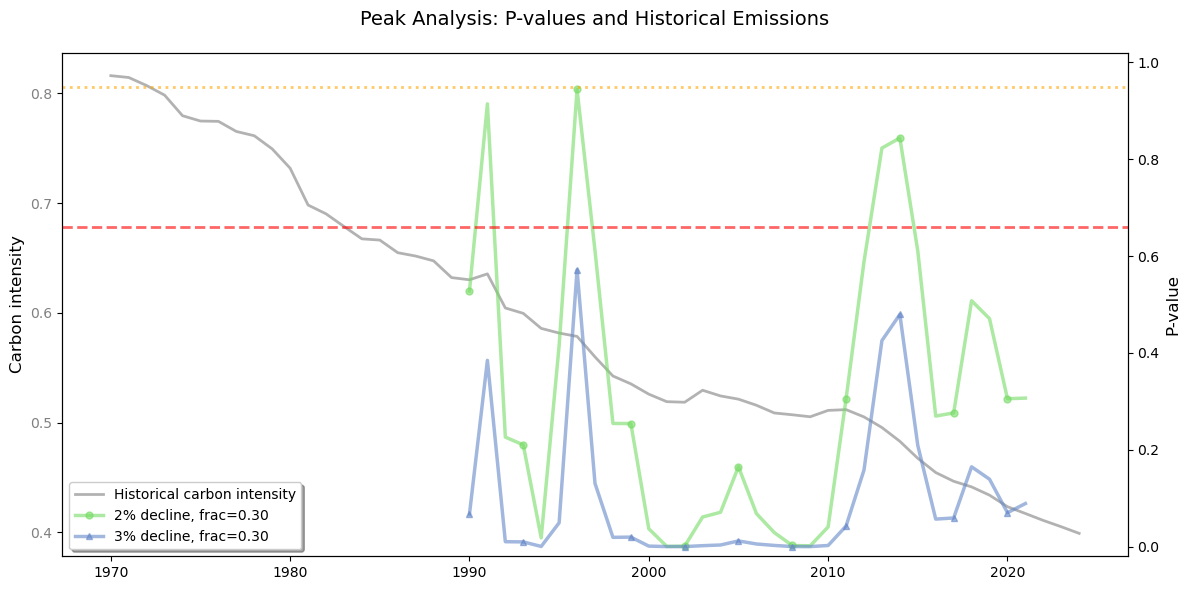

In [57]:
# Plot p-values (carbon intensity)
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

df = flat_results

ci_tester = EmissionsPeakTest()
ci_tester.load_historical_data('carbon_intensity_gdp.csv', region = 'WLD', year_range = range(1970,2025))
hist_data = ci_tester.historical_data

# Plot emissions on the first y-axis
ax1.set_ylabel('Carbon intensity', color='black', fontsize=12)
ax1.plot(ci_tester.historical_data.year, ci_tester.historical_data.emissions, 
         color='gray', linewidth=2, label='Historical carbon intensity', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='grey')

# Create 2nd y axis for p-values
ax2 = ax1.twinx()
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('P-value', fontsize=12)

# Define color palettes for each null hypothesis
# Greens for null_hypothesis = 0.02 (2% annual decline)
green_palette = {
    0.150: '#1b4f0a',   # Darkest green
    0.175: '#2d6b1c',
    0.200: '#3f872e',
    0.225: '#51a340',
    0.250: '#63bf52',
    0.300: '#75db64'    # Lightest green
}

# Blues for null_hypothesis = 0.03 (3% annual decline) 
blue_palette = {
    0.150: '#0a1e3c',   # Darkest blue
    0.175: '#1c3358',
    0.200: '#2e4874',
    0.225: '#405d90',
    0.250: '#5272ac',
    0.300: '#6487c8'    # Lightest blue
}

# Use all fractions for comprehensive view, or subset for clarity
fractions_to_show = [0.1, 0.15, 0.2, 0.3]  # Simplified view
# fractions_to_show = sorted(df['fraction'].unique())  # All fractions

# Store plotted lines for legend management
plotted_lines = []

# Plot each null hypothesis and fraction combination
for null_hyp in sorted(df['null_hypothesis'].unique()):
    # Select appropriate color palette
    colors = green_palette if null_hyp == 0.02 else blue_palette
    
    for fraction in fractions_to_show:
        # Filter data
        mask = (df['null_hypothesis'] == null_hyp) & (df['parameters'] == {'fraction': fraction})
        data_subset = df[mask].sort_values('year')
        
        if len(data_subset) > 0:
            # Get color for this fraction
            color = colors.get(fraction, 'gray')
            
            # Style variations
            marker = 'o' if null_hyp == 0.02 else '^'
            linewidth = 2.5 if fraction in [0.15, 0.30] else 1.8
            alpha = 0.8 if fraction in [0.15, 0.20] else 0.6
            markersize = 5 if fraction in [0.15, 0.30] else 3
            
            # Plot the line
            label = f'{int(null_hyp*100)}% decline, frac={fraction:.2f}'
            line, = ax2.plot(data_subset['year'], 1 - data_subset['p-value'], 
                           color=color, marker=marker,
                           linewidth=linewidth, alpha=alpha,
                           markersize=markersize, 
                           markevery=3,  # Show marker every 3rd point
                           label=label)
            plotted_lines.append((line, null_hyp, fraction))




# Add horizontal line at 1-p=0.66 for reference
# ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66 threshold')

# Add reference lines
ref_line1 = ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.6, linewidth=2)
ref_line2 = ax2.axhline(y=0.95, color='orange', linestyle=':', alpha=0.6, linewidth=2)

# Highlight regions of significance
# ax2.axhspan(0.95, 1.0, alpha=0.08, color='green')
# ax2.axhspan(0.66, 0.95, alpha=0.04, color='yellow')

ax2.set_ylim(-0.02, 1.02)

# Add title and format
plt.title('Peak Analysis: P-values and Historical Emissions', fontsize=14, pad=20)
fig.tight_layout()

# Add legends - combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', frameon=True, 
           fancybox=True, shadow=True)


In [64]:
# Results from runs with different null hypotheses and fractions
results = pd.read_csv('results/ci_fraction_tests_0203_contd.csv')

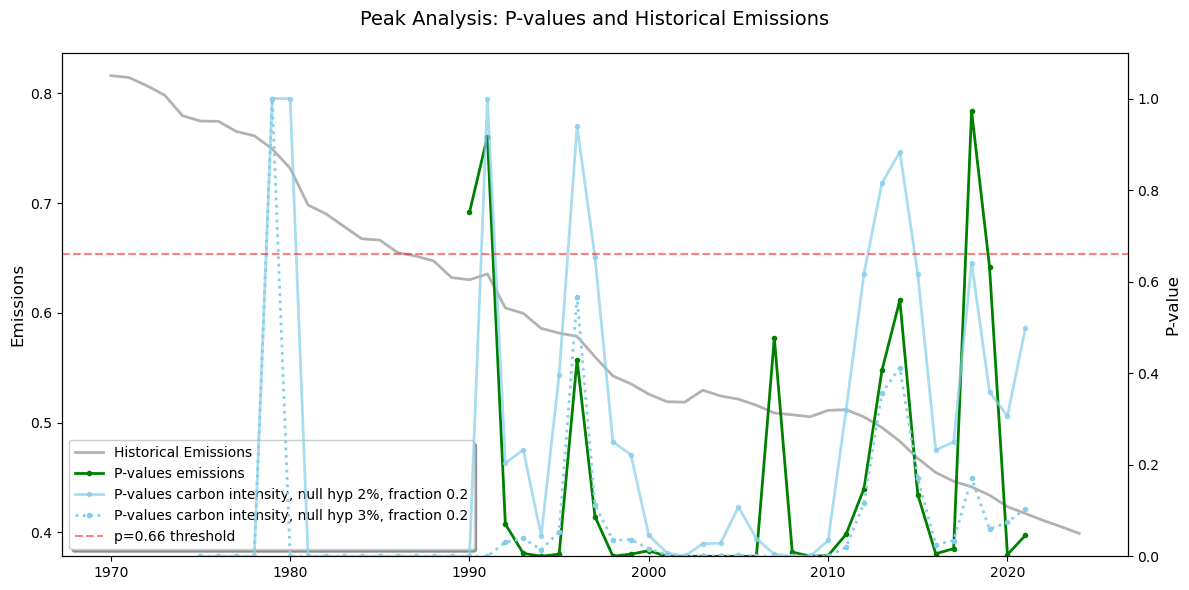

In [65]:
# Plot both emissions and CI

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot emissions on the first y-axis

ax1.set_ylabel('Emissions', color='black', fontsize=12)
ax1.plot(hist_data.year, hist_data.emissions, 
         color='gray', linewidth=2, label='Historical Emissions', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='black')

# Create 2nd y axis for p-values
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('P-value', color='black', fontsize=12)

#p values for emissions
pdf = pdf_3year.copy()

#p values for CI
results = pd.read_csv('results/ci_fraction_tests_0203_contd.csv')
pdf2 = results.loc[(results['fraction']==0.2) & (results['null_hypothesis']== 0.02)]
pdf3 = results.loc[(results['fraction']==0.2) & (results['null_hypothesis']== 0.03)]

ax2.plot(pdf['year'], 1-pdf['p-value'], color='green', marker='o', 
         linewidth=2, label='P-values emissions', markersize=3)



ax2.plot(pdf2['year'], 1-pdf2['p-value'], color='skyblue', marker='o', 
         linewidth=2, label='P-values carbon intensity, null hyp 2%, fraction 0.2', markersize=3, alpha = 0.7)

ax2.plot(pdf3['year'], 1-pdf3['p-value'], color='skyblue', marker='o', 
         linewidth=2, label='P-values carbon intensity, null hyp 3%, fraction 0.2', markersize=3, linestyle = 'dotted')


# Add horizontal line at 1-p=0.66 for reference
ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66 threshold')
# Set y-limits for p-values with some padding

ax2.set_ylim(0, 1.1)



# Add title and format
plt.title('Peak Analysis: P-values and Historical Emissions', fontsize=14, pad=20)
fig.tight_layout()

# Add legends - combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', frameon=True, 
           fancybox=True, shadow=True)
plt.savefig("../figures/pvalue_analysis_ci.png", dpi=300, bbox_inches='tight')
plt.show()

## CI with a dynamic null hypothesis (not used)

In [50]:
# Create dynamic GDP curve

gdp_tester = EmissionsPeakTest()
gdp_tester.load_historical_data(
    'wdi_gdp.csv', region = 'WLD', year_range = range(1975,2024))

# calculate annualised gdp growth
gdp = gdp_tester.historical_data
gdp['gdp_3yr_cagr'] = np.power(gdp['emissions'] / gdp['emissions'].shift(3), 1/3) -1

# add dynamic GDP growth rate
ci_tester = EmissionsPeakTest()
ci_tester.load_historical_data('carbon_intensity_updated.csv', region = 'WLD', year_range = range(1971,2024))

hist_data = ci_tester.historical_data
p_list = []
years_to_check = np.arange(1991, 2022, 1)
for year in years_to_check:
    years_to_test = [year, year+1, year+2]
    
    em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
    em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()
    em_2 = hist_data.loc[hist_data.year==year+2,'emissions'].squeeze()

    gdp_growth_rate = gdp.loc[gdp['year']==year+2, 'gdp_3yr_cagr'] #take growth rate of the 3 years to test

    # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
    with HiddenPrints():
        ci_tester.historical_data = hist_data.query(f'year <= {year}').copy()
        ci_tester.characterize_noise(method='loess', fraction = 0.2, noise_type = 't-dist') # 
        ci_tester.create_noise_generator()
        ci_tester.set_test_data([
                (year, em_0),
                (year+1, em_1), 
                (year+2, em_2),
            ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap', null_hypothesis=em_0*float(-1*gdp_growth_rate))
        p_list.append(ci_tester.bootstrap_results['p_value_one_tail'])
    
pdf_ci_dynamic = pd.DataFrame({
    'year': years_to_check,
    'p-value': p_list
})


Loaded historical data: 1975-2023
Data points: 49
Loaded historical data: 1971-2023
Data points: 53


In [51]:
pdf_ci_dynamic.to_csv('results/ci_dynamic_growth_frac02.csv')

Loaded historical data: 1971-2023
Data points: 53


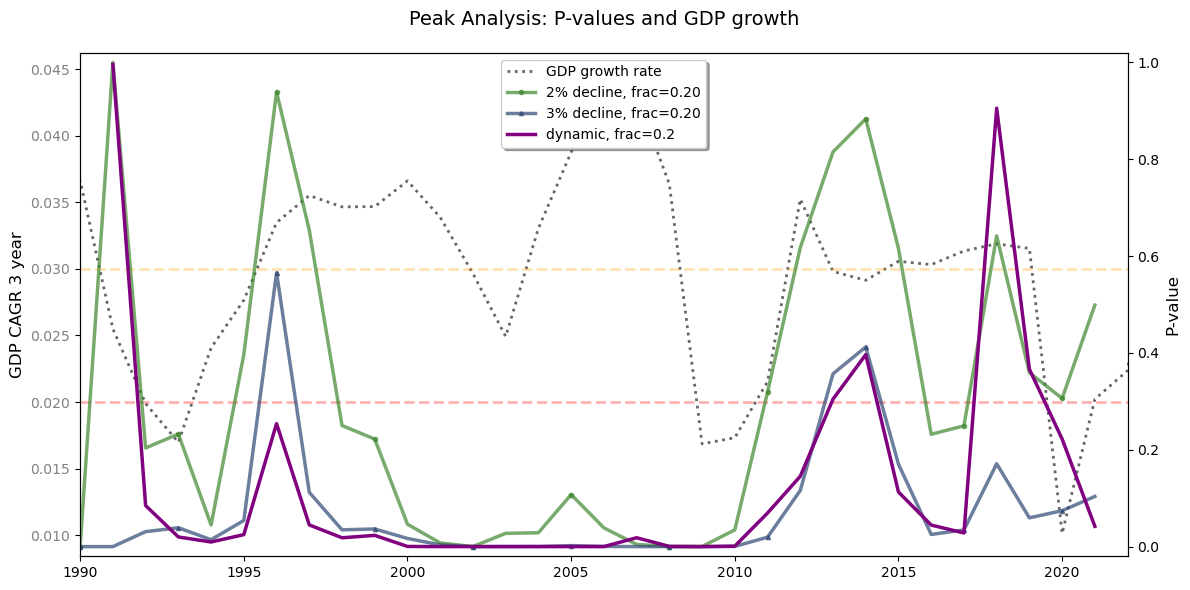

In [76]:
# Plot p-values (carbon intensity)
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

df = pd.read_csv('results/ci_fraction_tests_0203_contd.csv')
df_dy = pd.read_csv('results/ci_dynamic_growth_frac02.csv')

ci_tester = EmissionsPeakTest()
ci_tester.load_historical_data('carbon_intensity_updated.csv', region = 'WLD', year_range = range(1971,2024))
hist_data = ci_tester.historical_data

# Plot emissions on the first y-axis
ax1.set_ylabel('GDP CAGR 3 year', color='black', fontsize=12)
# ax1.plot(ci_tester.historical_data.year, ci_tester.historical_data.emissions, 
#          color='gray', linewidth=2, label='Historical carbon intensity', alpha=0.6)
ax1.plot(gdp['year'], gdp['gdp_3yr_cagr'], color = 'black', alpha = 0.6, label = 'GDP growth rate', linewidth=2, linestyle='dotted')
ax1.tick_params(axis='y', labelcolor='grey')
ref_line1 = ax1.axhline(y=0.02, color='red', linestyle='--', alpha=0.3, linewidth=2)
ref_line2 = ax1.axhline(y=0.03, color='orange', linestyle='--', alpha=0.3, linewidth=2)

# Create 2nd y axis for p-values
ax2 = ax1.twinx()
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('P-value', fontsize=12)

# Define color palettes for each null hypothesis
# Greens for null_hypothesis = 0.02 (2% annual decline)
green_palette = {
    0.150: '#1b4f0a',   # Darkest green
    0.175: '#2d6b1c',
    0.200: '#3f872e',
    0.225: '#51a340',
    0.250: '#63bf52',
    0.300: '#75db64'    # Lightest green
}

# Blues for null_hypothesis = 0.03 (3% annual decline) 
blue_palette = {
    0.150: '#0a1e3c',   # Darkest blue
    0.175: '#1c3358',
    0.200: '#2e4874',
    0.225: '#405d90',
    0.250: '#5272ac',
    0.300: '#6487c8'    # Lightest blue
}

# Use all fractions for comprehensive view, or subset for clarity
fractions_to_show = [0.2]  # Simplified view
# fractions_to_show = sorted(df['fraction'].unique())  # All fractions

# Store plotted lines for legend management
plotted_lines = []

# Plot each null hypothesis and fraction combination
for null_hyp in sorted(df['null_hypothesis'].unique()):
    # Select appropriate color palette
    colors = green_palette if null_hyp == 0.02 else blue_palette
    
    for fraction in fractions_to_show:
        # Filter data
        mask = (df['null_hypothesis'] == null_hyp) & (df['fraction'] == fraction)
        data_subset = df[mask].sort_values('year')
        
        if len(data_subset) > 0:
            # Get color for this fraction
            color = colors.get(fraction, 'gray')
            
            # Style variations
            marker = 'o' if null_hyp == 0.02 else '^'
            linewidth = 2.5 if fraction in [0.15, 0.175, 0.20] else 1.8
            alpha = 0.9 if fraction in [0.15, 0.30] else 0.7
            markersize = 5 if fraction in [0.15, 0.30] else 3
            
            # Plot the line
            label = f'{int(null_hyp*100)}% decline, frac={fraction:.2f}'
            line, = ax2.plot(data_subset['year'], 1 - data_subset['p-value'], 
                           color=color, marker=marker,
                           linewidth=linewidth, alpha=alpha,
                           markersize=markersize, 
                           markevery=3,  # Show marker every 3rd point
                           label=label)
            plotted_lines.append((line, null_hyp, fraction))

ax2.plot(df_dy['year'], 1 - df_dy['p-value'], color = 'purple', label = 'dynamic, frac=0.2', linewidth = 2.5)


# Add horizontal line at 1-p=0.66 for reference
# ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66 threshold')

# Add reference lines
# ref_line1 = ax2.axhline(y=0.66, color='red', linestyle='--', alpha=0.6, linewidth=2)
# ref_line2 = ax2.axhline(y=0.95, color='orange', linestyle=':', alpha=0.6, linewidth=2)

# Highlight regions of significance
# ax2.axhspan(0.95, 1.0, alpha=0.08, color='green')
# ax2.axhspan(0.66, 0.95, alpha=0.04, color='yellow')

ax2.set_ylim(-0.02, 1.02)
ax2.set_xlim(1990, 2022)

# Add title and format
plt.title('Peak Analysis: P-values and GDP growth', fontsize=14, pad=20)
fig.tight_layout()

# Add legends - combining both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', frameon=True, 
           fancybox=True, shadow=True)

# Test fractions for LOESS

## Investigating role of different fractions on emissions calculations

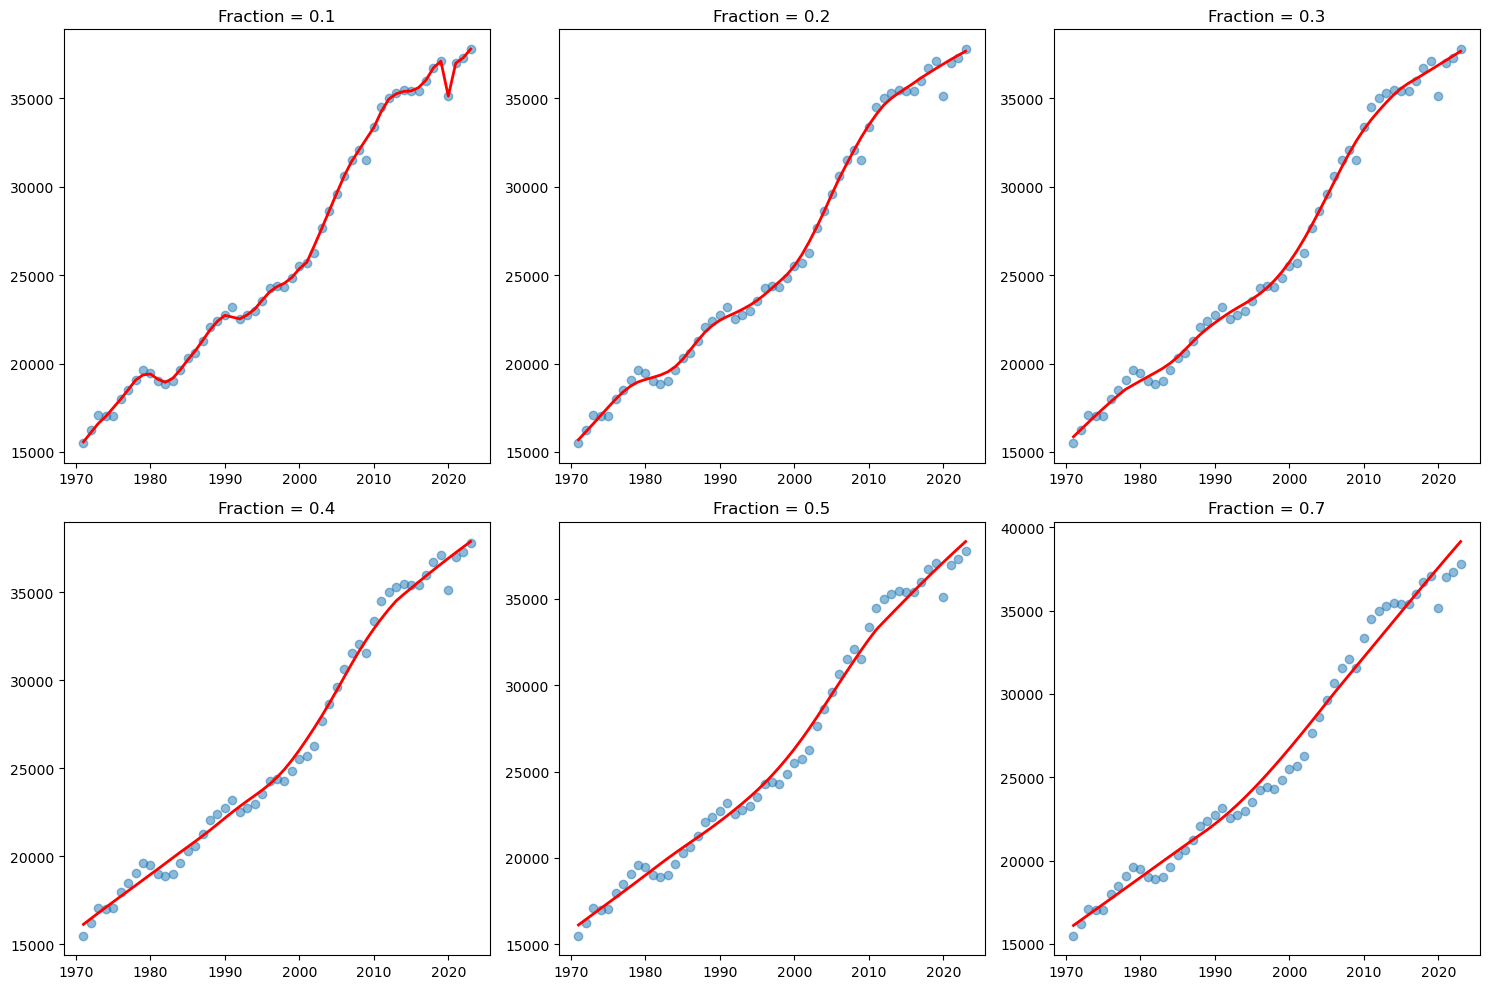

In [174]:

emissions = peak_tester.historical_data['emissions']
years = peak_tester.historical_data['year']

# Test multiple fractions
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, frac in enumerate(fractions):
    lowess = sm.nonparametric.lowess(emissions, years, frac=frac)
    axes[i].scatter(years, emissions, alpha=0.5)
    axes[i].plot(lowess[:, 0], lowess[:, 1], 'r-', linewidth=2)
    axes[i].set_title(f'Fraction = {frac}')


# plt.xlim([1990, 2023])
plt.tight_layout()
plt.show()

In [162]:

peak_tester2 = EmissionsPeakTest()
peak_tester2.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,2024))
hist_data = peak_tester2.historical_data

years_to_check = np.arange(1975, 2022, 1)
all_results = []

for frac in [0.1, 0.15, 0.2, 0.25, 0.3]:

    for year in years_to_check:
        years_to_test = [year, year+1, year+2]
        
        em_0 = hist_data.loc[hist_data.year==year,'emissions'].squeeze()
        em_1 = hist_data.loc[hist_data.year==year+1,'emissions'].squeeze()
        em_2 = hist_data.loc[hist_data.year==year+2,'emissions'].squeeze()
    
        # peak_tester.load_historical_data('gcb_hist_co2.csv', year_range = range(1971,year))
        with HiddenPrints():
            peak_tester2.historical_data = hist_data.query(f'year <= {year}').copy()
            peak_tester2.characterize_noise(method='loess', frac = frac, noise_type = 't-dist') # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
            peak_tester2.create_noise_generator()
            peak_tester2.set_test_data([
                    (year, em_0),
                    (year+1, em_1), 
                    # (year+2, em_2),
                ]).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
            all_results.append({
                'year': year,
                'frac': frac,
                'p-value': peak_tester2.bootstrap_results['p_value_one_tail']
            })
        
df_frac = pd.DataFrame(all_results)


Loaded historical data: 1971-2023
Data points: 53


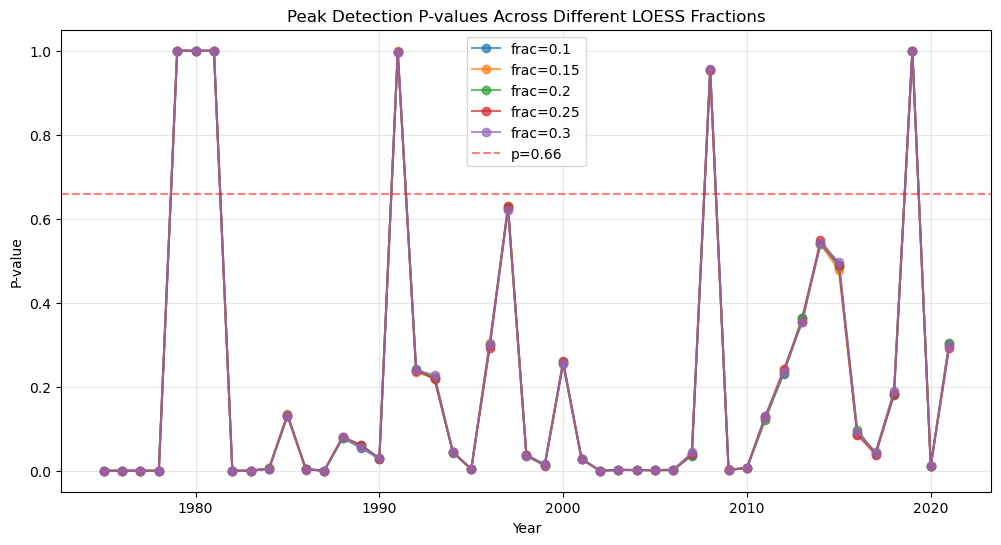

In [166]:
fig, ax = plt.subplots(figsize=(12, 6))


for frac in [0.1, 0.15, 0.2, 0.25, 0.3]:
    df = df_frac[df_frac['frac'] == frac]
    ax.plot(df['year'], 1-df['p-value'], 
            marker='o', label=f'frac={frac}', alpha=0.7)

ax.axhline(y=0.66, color='red', linestyle='--', alpha=0.5, label='p=0.66')
ax.set_xlabel('Year')
ax.set_ylabel('P-value')
ax.set_title('Peak Detection P-values Across Different LOESS Fractions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## Investigating impact of different fractions on carbon intensity calcuations

IndexError: index 6 is out of bounds for axis 0 with size 6

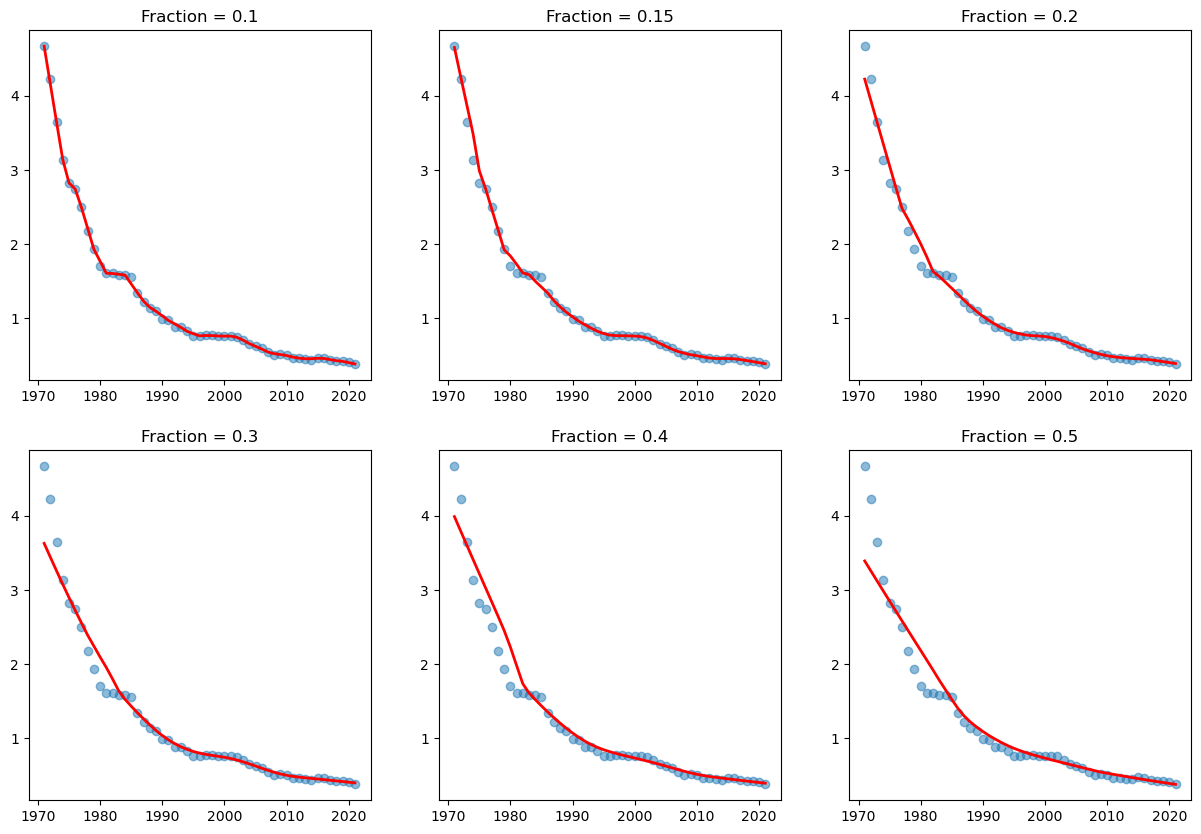

In [175]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

ci = ci_tester.historical_data['emissions']
years = ci_tester.historical_data['year']

# Test multiple fractions
fractions = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, frac in enumerate(fractions):
    lowess = sm.nonparametric.lowess(ci, years, frac=frac)
    axes[i].scatter(years, ci, alpha=0.5)
    axes[i].plot(lowess[:, 0], lowess[:, 1], 'r-', linewidth=2)
    axes[i].set_title(f'Fraction = {frac}')


plt.xlim([1990, 2023])
plt.tight_layout()
plt.show()


In [126]:
from sklearn.model_selection import KFold, LeaveOneOut


def loess_cv_detailed(fractions, x, y, cv_method='timeseries', k=5, random_state=42):
    """
    Comprehensive cross-validation for LOESS fraction selection
    
    Parameters:
    - fractions: array of fractions to test
    - x, y: your data
    - cv_method: 'kfold', 'loo' (leave-one-out), or 'timeseries'
    - k: number of folds for k-fold CV
    """
    
    results = {
        'fractions': fractions,
        'mean_mse': [],
        'std_mse': [],
        'mean_mae': [],
        'std_mae': []
    }
    
    for frac in fractions:
        mse_scores = []
        mae_scores = []
        
        if cv_method == 'kfold':
            # K-Fold: randomly splits data into k groups
            kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
            splits = kf.split(x)
            
        elif cv_method == 'loo':
            # Leave-One-Out: each point is test set once
            loo = LeaveOneOut()
            splits = loo.split(x)
            
        elif cv_method == 'timeseries':
            # Time series split: respects temporal order
            from sklearn.model_selection import TimeSeriesSplit
            tscv = TimeSeriesSplit(n_splits=k)
            splits = tscv.split(x)
        
        for train_idx, test_idx in splits:
            # Split data
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            try:
                # Fit LOESS on training data
                lowess = sm.nonparametric.lowess(y_train, x_train, frac=frac)
                
                # Predict on test data using interpolation
                # Sort lowess results by x values for proper interpolation
                sorted_idx = np.argsort(lowess[:, 0])
                x_smooth = lowess[sorted_idx, 0]
                y_smooth = lowess[sorted_idx, 1]
                
                # Interpolate predictions for test points
                y_pred = np.interp(x_test, x_smooth, y_smooth)
                
                # Calculate errors
                mse = np.mean((y_test - y_pred) ** 2)
                mae = np.mean(np.abs(y_test - y_pred))
                
                mse_scores.append(mse)
                mae_scores.append(mae)
                
            except:
                # Handle cases where LOESS fails (too few points)
                continue
        
        # Store results
        results['mean_mse'].append(np.mean(mse_scores))
        results['std_mse'].append(np.std(mse_scores))
        results['mean_mae'].append(np.mean(mae_scores))
        results['std_mae'].append(np.std(mae_scores))
    
    return pd.DataFrame(results)

Optimal fraction for peak detection: 0.080


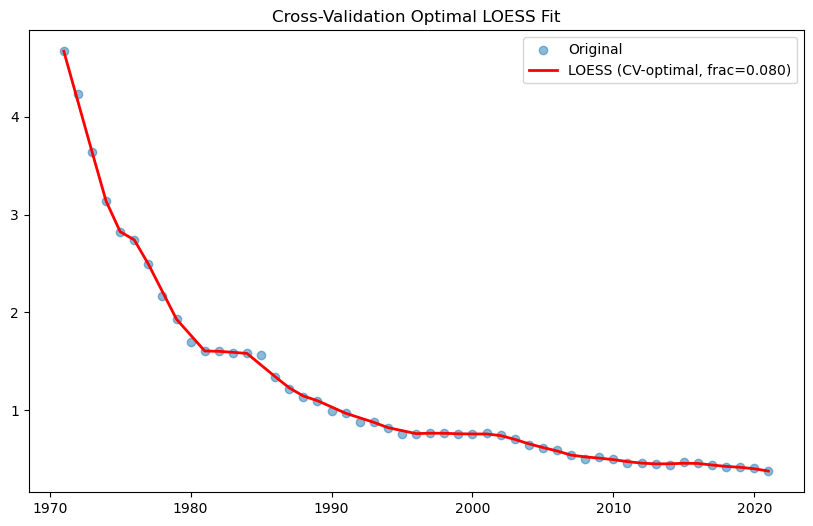

In [130]:
# Recommended approach for emissions peak detection
fractions = np.arange(0.05, 0.4, 0.01)  # Focus on smaller fractions
cv_results = loess_cv_detailed(fractions, years.values, ci.values, 
                                cv_method='loo')

optimal_frac = cv_results.loc[cv_results['mean_mse'].idxmin(), 'fractions']
print(f"Optimal fraction for peak detection: {optimal_frac:.3f}")

# Verify it preserves the peak
lowess_optimal = sm.nonparametric.lowess(ci, years, frac=optimal_frac)
plt.figure(figsize=(10, 6))
plt.scatter(years, ci, alpha=0.5, label='Original')
plt.plot(lowess_optimal[:, 0], lowess_optimal[:, 1], 'r-', 
         linewidth=2, label=f'LOESS (CV-optimal, frac={optimal_frac:.3f})')
plt.legend()
plt.title('Cross-Validation Optimal LOESS Fit')
plt.show()

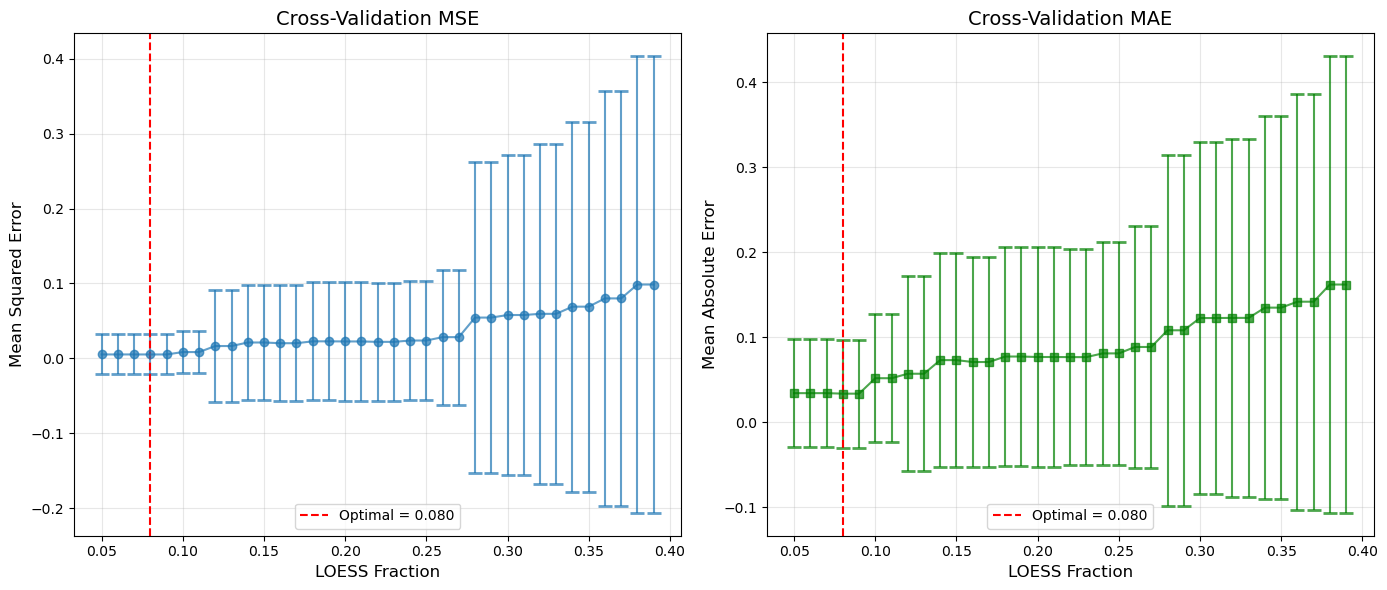

In [137]:
def plot_cv_results(cv_results):
    """Visualize cross-validation results with confidence intervals"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot MSE with error bars
    ax1 = axes[0]
    ax1.errorbar(cv_results['fractions'], 
                 cv_results['mean_mse'],
                 yerr=cv_results['std_mse'],
                 marker='o', capsize=5, capthick=2, alpha=0.7)
    
    optimal_idx = cv_results['mean_mse'].idxmin()
    ax1.axvline(cv_results.loc[optimal_idx, 'fractions'], 
                color='red', linestyle='--', 
                label=f'Optimal = {cv_results.loc[optimal_idx, "fractions"]:.3f}')
    
    ax1.set_xlabel('LOESS Fraction', fontsize=12)
    ax1.set_ylabel('Mean Squared Error', fontsize=12)
    ax1.set_title('Cross-Validation MSE', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot MAE with error bars
    ax2 = axes[1]
    ax2.errorbar(cv_results['fractions'], 
                 cv_results['mean_mae'],
                 yerr=cv_results['std_mae'],
                 marker='s', capsize=5, capthick=2, alpha=0.7, color='green')
    
    optimal_mae_idx = cv_results['mean_mae'].idxmin()
    ax2.axvline(cv_results.loc[optimal_mae_idx, 'fractions'], 
                color='red', linestyle='--',
                label=f'Optimal = {cv_results.loc[optimal_mae_idx, "fractions"]:.3f}')
    
    ax2.set_xlabel('LOESS Fraction', fontsize=12)
    ax2.set_ylabel('Mean Absolute Error', fontsize=12)
    ax2.set_title('Cross-Validation MAE', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize the results
plot_cv_results(cv_results)

In [121]:
def time_series_cv(fractions, x, y, min_train_size=10, horizon=3):
    """
    Special CV for time series that respects temporal order
    
    Parameters:
    - min_train_size: minimum training set size
    - horizon: how many points ahead to predict
    """
    
    n = len(x)
    results = []
    
    for frac in fractions:
        errors = []
        
        # Rolling window approach
        for split_point in range(min_train_size, n - horizon):
            # Training: all data up to split_point
            x_train = x[:split_point]
            y_train = y[:split_point]
            
            # Test: next 'horizon' points
            x_test = x[split_point:split_point + horizon]
            y_test = y[split_point:split_point + horizon]
            
            # Fit and predict
            lowess = sm.nonparametric.lowess(y_train, x_train, frac=frac)
            y_pred = np.interp(x_test, lowess[:, 0], lowess[:, 1])
            
            # Calculate error
            mse = np.mean((y_test - y_pred) ** 2)
            errors.append(mse)
        
        results.append({
            'fraction': frac,
            'mean_error': np.mean(errors),
            'std_error': np.std(errors)
        })
    
    return pd.DataFrame(results)

# For emissions time series
ts_cv_results = time_series_cv(fractions, years.values, ci.values, 
                                min_train_size=15, horizon=2)

optimal_ts_frac = ts_cv_results.loc[ts_cv_results['mean_error'].idxmin(), 'fraction']
print(f"Optimal fraction for time series: {optimal_ts_frac:.3f}")

Optimal fraction for time series: 0.240


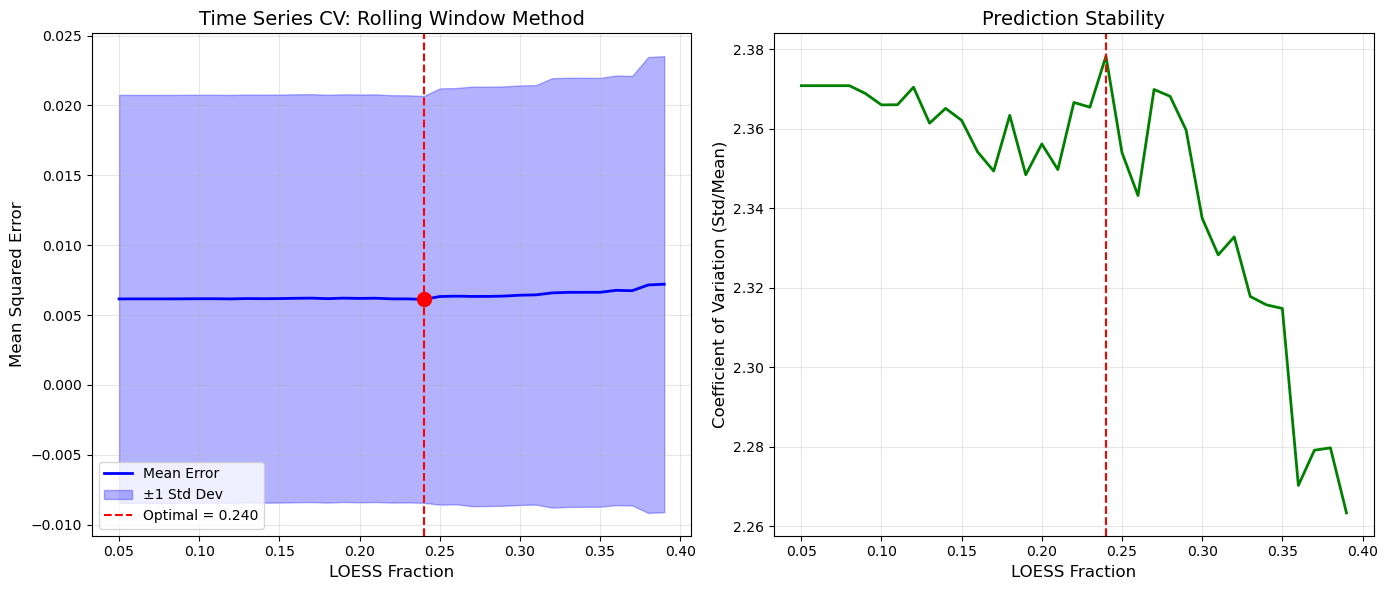

Optimal fraction: 0.240
Error at optimal: 0.0061 ± 0.0146


In [138]:
def plot_ts_cv_results(ts_cv_results):
    """Plot time series cross-validation results"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Mean error with standard deviation bands
    ax1 = axes[0]
    ax1.plot(ts_cv_results['fraction'], ts_cv_results['mean_error'], 
             'b-', linewidth=2, label='Mean Error')
    
    # Add confidence bands
    ax1.fill_between(ts_cv_results['fraction'],
                     ts_cv_results['mean_error'] - ts_cv_results['std_error'],
                     ts_cv_results['mean_error'] + ts_cv_results['std_error'],
                     alpha=0.3, color='blue', label='±1 Std Dev')
    
    # Mark optimal
    optimal_idx = ts_cv_results['mean_error'].idxmin()
    optimal_frac = ts_cv_results.loc[optimal_idx, 'fraction']
    optimal_error = ts_cv_results.loc[optimal_idx, 'mean_error']
    
    ax1.axvline(optimal_frac, color='red', linestyle='--', 
                label=f'Optimal = {optimal_frac:.3f}')
    ax1.scatter(optimal_frac, optimal_error, color='red', s=100, zorder=5)
    
    ax1.set_xlabel('LOESS Fraction', fontsize=12)
    ax1.set_ylabel('Mean Squared Error', fontsize=12)
    ax1.set_title('Time Series CV: Rolling Window Method', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Coefficient of variation (relative variability)
    ax2 = axes[1]
    cv_coefficient = ts_cv_results['std_error'] / ts_cv_results['mean_error']
    ax2.plot(ts_cv_results['fraction'], cv_coefficient, 
             'g-', linewidth=2)
    ax2.axvline(optimal_frac, color='red', linestyle='--')
    
    ax2.set_xlabel('LOESS Fraction', fontsize=12)
    ax2.set_ylabel('Coefficient of Variation (Std/Mean)', fontsize=12)
    ax2.set_title('Prediction Stability', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Optimal fraction: {optimal_frac:.3f}")
    print(f"Error at optimal: {optimal_error:.4f} ± {ts_cv_results.loc[optimal_idx, 'std_error']:.4f}")

# Plot your results
plot_ts_cv_results(ts_cv_results)

Optimal fraction for time series: 0.200


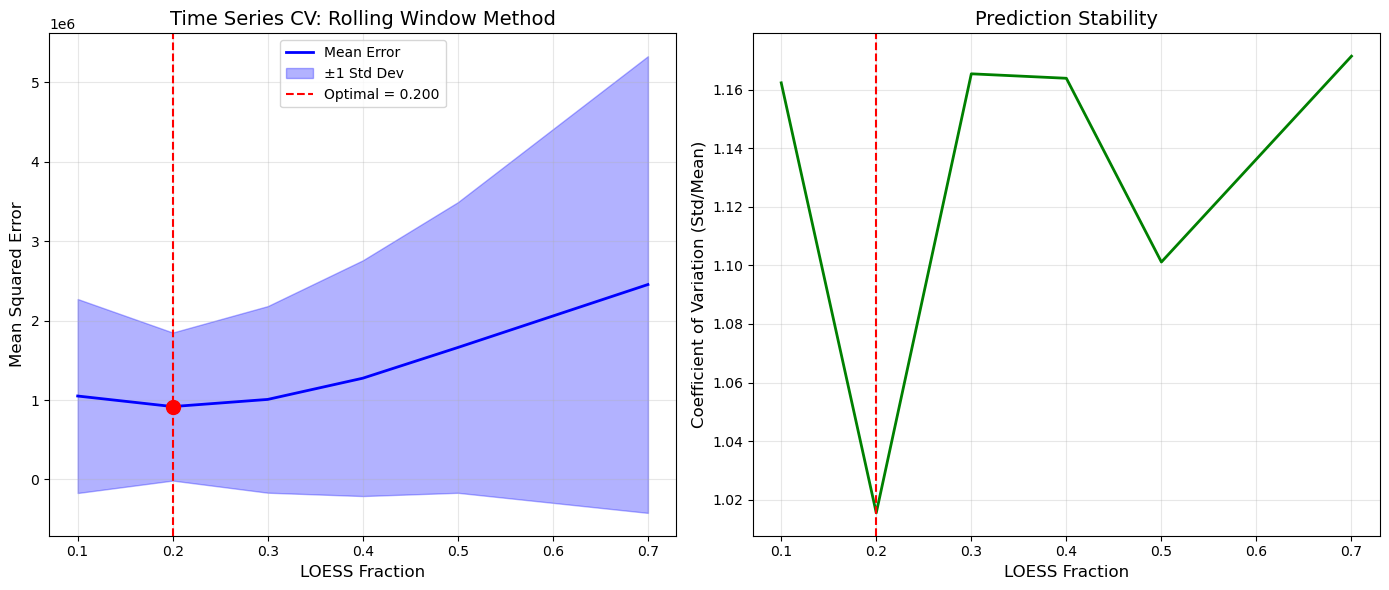

Optimal fraction: 0.200
Error at optimal: 917368.8491 ± 931535.3913


In [157]:
ts_cv_results_emissions = time_series_cv(fractions, years.values, emissions.values, 
                                min_train_size=15, horizon=2)

optimal_ts_frac_emissions = ts_cv_results_emissions.loc[ts_cv_results_emissions['mean_error'].idxmin(), 'fraction']
print(f"Optimal fraction for time series: {optimal_ts_frac_emissions:.3f}")
plot_ts_cv_results(ts_cv_results_emissions)

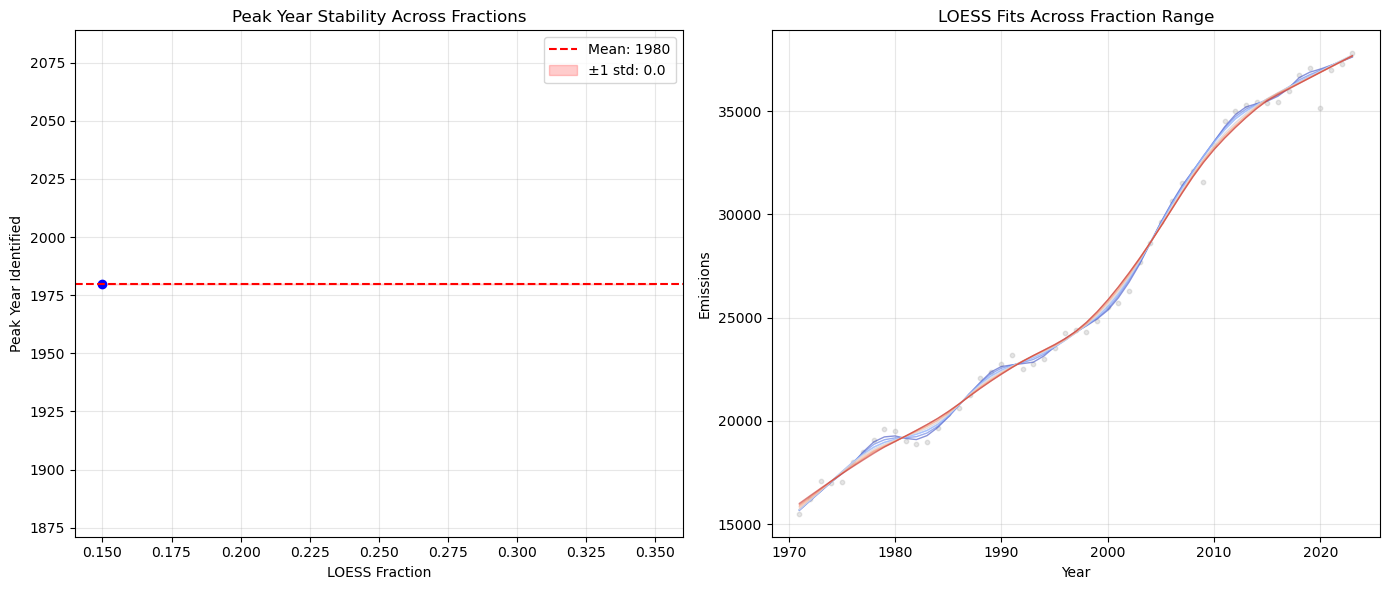

Peak Year Statistics (across fractions 0.15-0.35):
  Mean peak year: 1980.0
  Std deviation: 0.0 years
  Range: 1980 - 1980
  → CONSISTENT: Peak identification is stable across fractions


In [142]:
from scipy.signal import find_peaks
def peak_consistency_test(x, y, fraction_range=(0.15, 0.35)):
    """
    Test if peak identification is consistent across different fractions
    """
    fractions = np.linspace(fraction_range[0], fraction_range[1], 20)
    peak_years = []
    peak_values = []
    
    for frac in fractions:
        lowess = sm.nonparametric.lowess(y, x, frac=frac)
        peaks, _ = find_peaks(lowess[:, 1], prominence=0.01)
        
        if len(peaks) > 0:
            peak_years.append(lowess[peaks[0], 0])
            peak_values.append(lowess[peaks[0], 1])
        else:
            peak_years.append(np.nan)
            peak_values.append(np.nan)
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Peak year vs fraction
    ax1 = axes[0]
    ax1.plot(fractions, peak_years, 'b-', linewidth=2, marker='o')
    ax1.set_xlabel('LOESS Fraction')
    ax1.set_ylabel('Peak Year Identified')
    ax1.set_title('Peak Year Stability Across Fractions')
    ax1.grid(True, alpha=0.3)
    
    # Add bands for consistent regions
    if not all(np.isnan(peak_years)):
        peak_years_clean = [y for y in peak_years if not np.isnan(y)]
        mean_year = np.mean(peak_years_clean)
        std_year = np.std(peak_years_clean)
        ax1.axhline(mean_year, color='red', linestyle='--', 
                   label=f'Mean: {mean_year:.0f}')
        ax1.fill_between(fractions, mean_year - std_year, mean_year + std_year,
                         alpha=0.2, color='red', label=f'±1 std: {std_year:.1f}')
        ax1.legend()
    
    # Plot 2: Show all fits
    ax2 = axes[1]
    ax2.scatter(x, y, alpha=0.2, s=10, color='gray', label='Data')
    
    # Color gradient for fractions
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(fractions)))
    
    for i, frac in enumerate(fractions[::2]):  # Plot every other for clarity
        lowess = sm.nonparametric.lowess(y, x, frac=frac)
        ax2.plot(lowess[:, 0], lowess[:, 1], color=colors[i*2], 
                alpha=0.6, linewidth=1)
    
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Emissions')
    ax2.set_title('LOESS Fits Across Fraction Range')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    peak_years_clean = [y for y in peak_years if not np.isnan(y)]
    if peak_years_clean:
        print(f"Peak Year Statistics (across fractions {fraction_range[0]:.2f}-{fraction_range[1]:.2f}):")
        print(f"  Mean peak year: {np.mean(peak_years_clean):.1f}")
        print(f"  Std deviation: {np.std(peak_years_clean):.1f} years")
        print(f"  Range: {min(peak_years_clean):.0f} - {max(peak_years_clean):.0f}")
        
        if np.std(peak_years_clean) < 2:
            print("  → CONSISTENT: Peak identification is stable across fractions")
        else:
            print("  → INCONSISTENT: Peak year varies significantly with fraction")

# Test consistency
emissions = peak_tester.historical_data['emissions']
years = peak_tester.historical_data['year']
peak_consistency_test(years.values, emissions.values, fraction_range=(0.15, 0.35))